# Can you help reduce employee left?

## 📖 Background
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

## 💾 The data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.  
 
| TYPE | VARIABLE | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **department** | STATIC       |The department the employee belongs to
| **promoted** | INPUT       |*1* if the employee was promoted in the previous 24 months, *0* otherwise
| **review** | OUTPUT       |The composite score the employee received in their last evaluation
| **projects** | INPUT       |Number of projects the employee is involved in
| **salary** | INPUT       |For confidentiality reasons, salary is in three tiers: *low*, *medium*, *high*
| **tenure** | STATIC       |Total number of years employee has been with the company
| **satisfaction** | OUTPUT       |A measure of employee satisfaction from surveys
| **avg_hrs_month** | INPUT       |Average hours the employee worked in a month
| **left** | KPI       |*yes* if the employeed left, otherwise *no*

I've added a **VARIABLE** column to indicate the type of variable contained in the data set:
| VARIABLE | DETAILS                                                              |
|:----------|:---------------------------------------------------------------------|
| STATIC    | A fixed variable that can't be adjusted, it just is what it is
| INPUT     | A variable that can be adjusted to improve retention
| OUTPUT    | A variable that's derived from other variables
| KPI       | The Key Performance Indicator that we will try and optimize

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


### Dataset

In [69]:
df = pd.read_csv('data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


### Turnover by Department

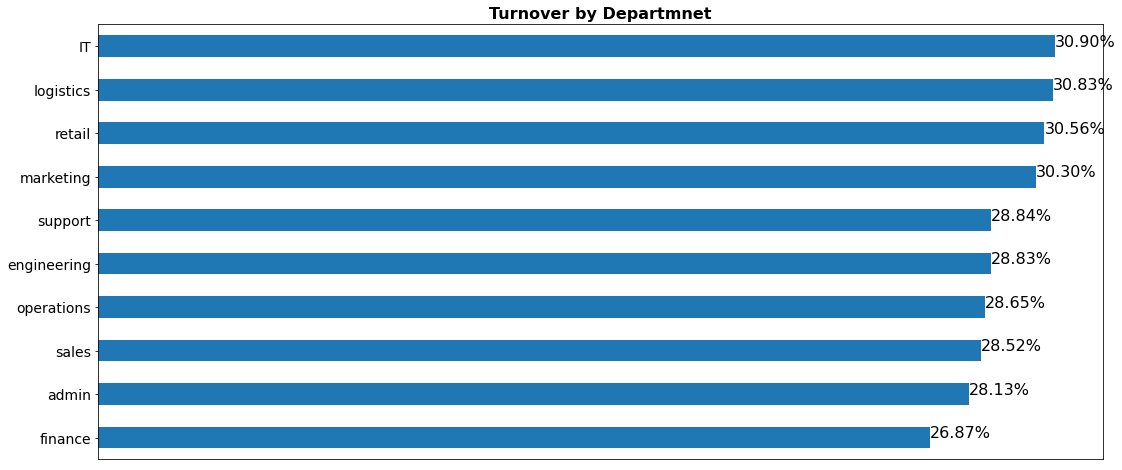

In [4]:
# Creating a new column to make it easier to measure left
df['turnover'] = 0
df.loc[df.left == 'yes', 'turnover'] = 1
df.groupby(['department'])[['turnover']].mean().sort_values('turnover').plot(kind = 'barh', figsize = (18,8), fontsize = 14)
plt.title('Turnover by Departmnet', fontsize = 16, fontweight = 'bold')
fmt = '${x:,.0f}'
c = 0
for i in df.groupby(['department'])[['turnover']].mean().sort_values('turnover')['turnover'].values:
    plt.text(i, float(c), '{:,.2f}%'.format(i*100), size = 16)
    c += 1
plt.legend().remove()
plt.ylabel('')
ax = plt.gca()
ax.get_xaxis().set_visible(False)

The **IT** Department has the worst turnover while **Finance** has the best.  

### Classifier Model
To identify which variables impact retention, we can identify a classifier model that can be tuned for our dataset.  To start, lets take a look at a few stock models and choose the one that works best out-of-the-box.

In [80]:
# Find the best stock model 
X = df.drop(["left", "turnover"], axis = 1)
X = pd.get_dummies(data=X, drop_first=True)
y = df['turnover']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Stock models
models = [AdaBoostClassifier(), BaggingClassifier(), GradientBoostingClassifier(), RandomForestClassifier()]
names = ['AdaBoostClassifier', 'BaggingClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier']
scores = []

for model in models:
    scores.append(round(np.mean(cross_val_score(model, X_train, y_train, cv = 10)), 4))

model_asses = pd.DataFrame(names, columns=['Models'])
model_asses['Corss-Validation Scores'] = scores
model_asses.sort_values(by='Corss-Validation Scores', ascending = False)


TypeError: Index(...) must be called with a collection of some kind, 'Models' was passed

Out-of-the-box, the **Random Forest Classifier** model appears to be the most accurate.  

### Feature Selection
Next we should identify which features are significant to properly tune our model.

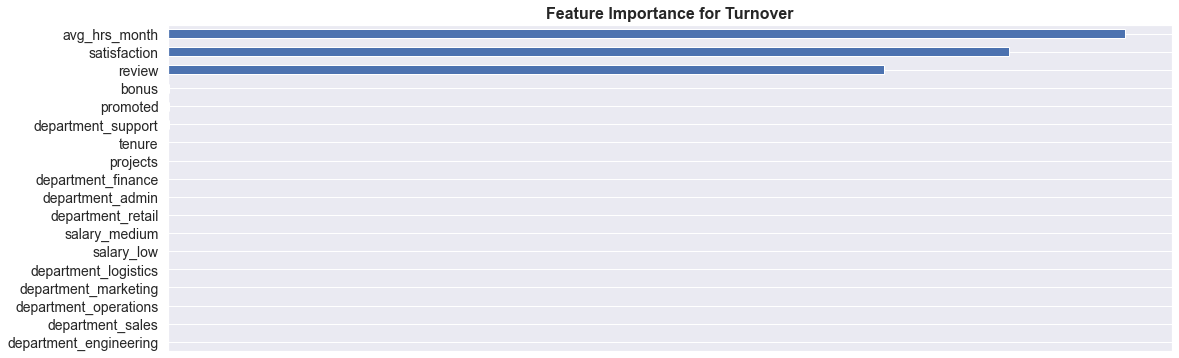

In [94]:
# Feature selection to determine predictors of turnover
## Create Random Forest Model
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
feature_names = [f"feature {i}" for i in range(X.shape[1])]
gbc = GradientBoostingClassifier().fit(X, y)
importances = gbc.feature_importances_
feature_dict = {
    'features': np.array(X.columns),
    'gbc': importances
}
gbc_df = pd.DataFrame.from_dict(feature_dict) 
gbc_df.set_index('features', inplace = True)
gbc_df.sort_values('gbc', inplace = True, ascending = True)
gbc_df.plot(kind = 'barh', figsize = (18,6), fontsize = 14)
plt.title('Feature Importance for Turnover', fontsize = 16, fontweight = 'bold')
plt.legend().remove()
plt.ylabel('')
ax = plt.gca()
ax.get_xaxis().set_visible(False)

The three most significant features would be **Satisfaction, Average Hours per Month, and Review**.  **Tenure** may be significant, but it's not a variable that can be controlled to optimize our KPI, so it will be downselected for now.  
Of our three significant **Average Hours per Month** is something that can absolutely be controlled while **Satisfaction** is not.  **Review** is a gray area.  It may be useful to intentionally inflate review numbers if it improved other variables like **Satisfaction**, but we'll wait to see if the data shows any indication of that.
Next, lets take a look to see if any of the variables signficantly impact **Satisfaction**.

### Model Selection

In [45]:
# Find the best stock model 
X = df.drop(["left", "turnover", "satisfaction", "department"], axis = 1)
X = pd.get_dummies(data=X, drop_first=True)
y = df['satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('AdaBoostRegressor: ' + str(round(np.mean(cross_val_score(AdaBoostRegressor(), X_train, y_train, cv = 10)), 4)*100) + '%')
print('BaggingRegressor: ' + str(round(np.mean(cross_val_score(BaggingRegressor(), X_train, y_train, cv = 10)), 4)*100) + '%')
print('GradientBoostingRegressor: ' + str(round(np.mean(cross_val_score(GradientBoostingRegressor(), X_train, y_train, cv = 10)), 4)*100) + '%')
print('RandomForestRegressor: ' + str(round(np.mean(cross_val_score(RandomForestRegressor(), X_train, y_train, cv = 10)), 4)*100) + '%')

AdaBoostRegressor: 12.16%
BaggingRegressor: 18.84%
GradientBoostingRegressor: 31.919999999999998%
RandomForestRegressor: 23.52%


### Model Tuning

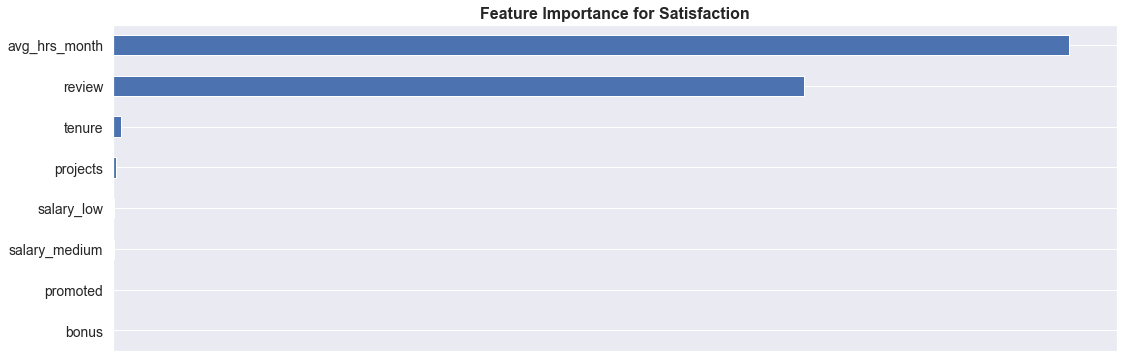

In [53]:
## Identify features for Random Forest Model
feature_names = [f"feature {i}" for i in range(X.shape[1])]
gradientboost = GradientBoostingRegressor().fit(X, y)
importances = gradientboost.feature_importances_
feature_dict = {
    'features': np.array(X.columns),
    'gradientboost': importances
}
gradientboost_df = pd.DataFrame.from_dict(feature_dict) 
gradientboost_df.set_index('features', inplace = True)
gradientboost_df.sort_values('gradientboost', inplace = True, ascending = True)
gradientboost_df.plot(kind = 'barh', figsize = (18,6), fontsize = 14)
plt.title('Feature Importance for Satisfaction', fontsize = 16, fontweight = 'bold')
plt.legend().remove()
plt.ylabel('')
ax = plt.gca()
ax.get_xaxis().set_visible(False)

Intersting find here that the **Average Number of Monthly Hours** has the biggest impact on satisfaction.  Lets repeat this one more time to see if there is anything that the company uses to set these hours.

In [96]:
X = df.drop(["left", "turnover", "avg_hrs_month"], axis = 1)
X = pd.get_dummies(data=X, drop_first=True)
y = df['avg_hrs_month']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Stock models
models = [AdaBoostRegressor(), BaggingRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]
names = ['AdaBoostRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'RandomForestRegressor']
scores = []

for model in models:
    scores.append(round(np.mean(cross_val_score(model, X_train, y_train, cv = 10)), 4))

model_asses = pd.DataFrame(names, columns=['Models'])
model_asses['Corss-Validation Scores'] = scores
model_asses.sort_values(by='Corss-Validation Scores', ascending = False)


,Models,Corss-Validation Scores
2,GradientBoostingRegressor,0.9610
3,RandomForestRegressor,0.9581
0,AdaBoostRegressor,0.9569
1,BaggingRegressor,0.9556


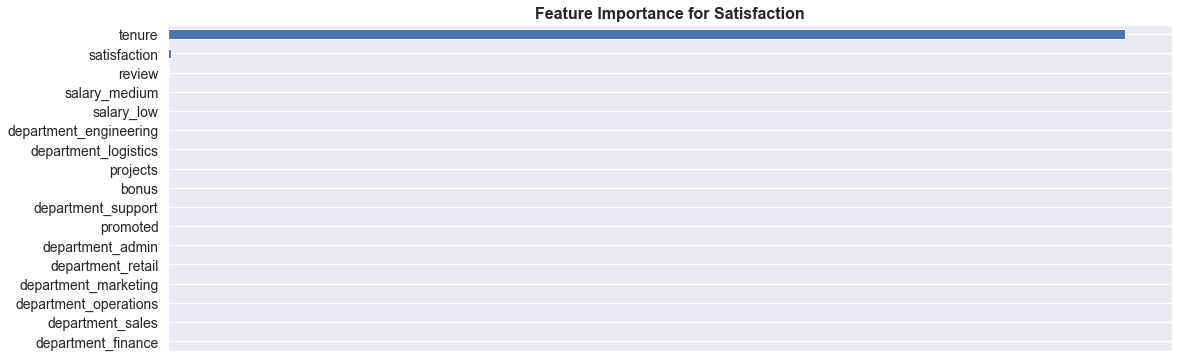

In [55]:

## Identify features for Random Forest Model
feature_names = [f"feature {i}" for i in range(X.shape[1])]
gradientboost = GradientBoostingRegressor().fit(X, y)
importances = gradientboost.feature_importances_
feature_dict = {
    'features': np.array(X.columns),
    'gradientboost': importances
}
gradientboost_df = pd.DataFrame.from_dict(feature_dict) 
gradientboost_df.set_index('features', inplace = True)
gradientboost_df.sort_values('gradientboost', inplace = True, ascending = True)
gradientboost_df.plot(kind = 'barh', figsize = (18,6), fontsize = 14)
plt.title('Feature Importance for Satisfaction', fontsize = 16, fontweight = 'bold')
plt.legend().remove()
plt.ylabel('')
ax = plt.gca()
ax.get_xaxis().set_visible(False)

Well this is incredibly helpful.  It appears the company preferentially sets hours based on tenure.  Lets dig into how tenure impaces the monthly hours for the employees.

Text(0.5, 1.0, 'Impact of Tenure on Monthly Hours')

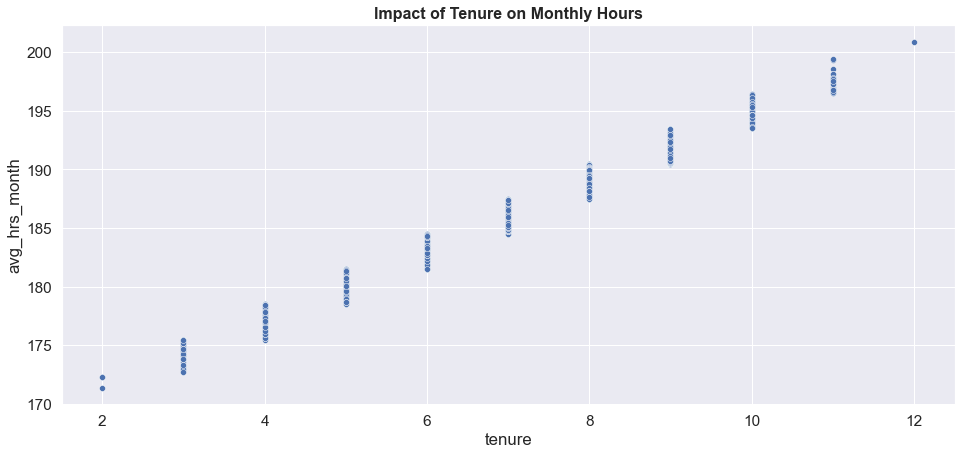

In [63]:
fig, ax = plt.subplots()
sns.set(
    font_scale=1.4
)
fig.set_size_inches([16,7])
ax = sns.scatterplot(
    y = df['avg_hrs_month'],
    x = df['tenure'],
)
# ax.set_xticklabels(['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100])
# ax.set_yticklabels(['{:,.1f}'.format(y) + '%' for y in ax.get_yticks()*100])

ax.set_title(
    "Impact of Tenure on Monthly Hours",
    fontsize = 16, 
    fontweight = 'bold'
)

This scatter helps visualize the company providing more hours for employees that have been with the company for longer.  I think it's safe to say, employees leaving are employees that have not been at the company long enough to get the hours they want or believe they deserve.  Lets confirm this suspicion.

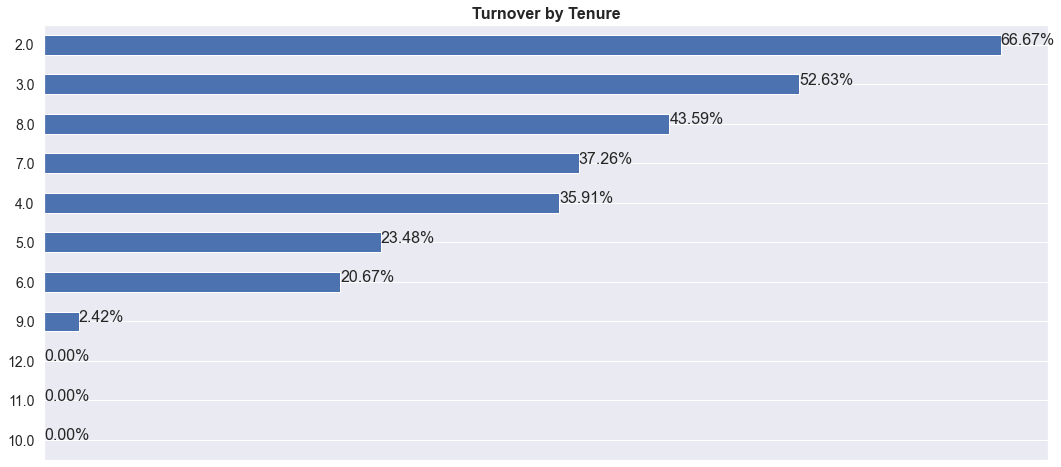

In [62]:
df.groupby(['tenure'])[['turnover']].mean().sort_values('turnover').plot(kind = 'barh', figsize = (18,8), fontsize = 14)
plt.title('Turnover by Tenure', fontsize = 16, fontweight = 'bold')
fmt = '${x:,.0f}'
c = 0
for i in df.groupby(['tenure'])[['turnover']].mean().sort_values('turnover')['turnover'].values:
    plt.text(i, float(c), '{:,.2f}%'.format(i*100), size = 16)
    c += 1
plt.legend().remove()
plt.ylabel('')
ax = plt.gca()
ax.get_xaxis().set_visible(False)

There appears to be two groups that significantly leave the company.  Lets run a simulation to see what would happen if we increase the hours for employees that have not been with the company at least 9 years.  Lets fit our classifier model for those leaving the company and see what the impact would be by increasing the hours of employees with less than 9 years tenure.

In [98]:
# Reducing predictors to only significate features
variables = ['avg_hrs_month', 'review', 'satisfaction', 'tenure']
X = df[variables]
y = df['left']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Grid search to optimize model
param_grid = {
    'loss': ['deviance','exponential'],
    'max_depth': [4, 5, 6, 7],
    'max_features': ['auto','sqrt','log2']
}
grid = GridSearchCV(GradientBoostingClassifier(), param_grid)
grid.fit(X_train, y_train)
print(grid.best_params_)


{'loss': 'exponential', 'max_depth': 5, 'max_features': 'auto'}


In [73]:
# Validate we didn't overfit
gbc = GradientBoostingClassifier(max_depth=13).fit(X_train, y_train)
print('Training Score: ' + str(round(np.mean(cross_val_score(RandomForestClassifier(max_depth=13), X_train, y_train, cv = 10)), 4)*100) + '%')
print('Testing Score: ' + str(round(np.mean(gbc.score(X_test, y_test)), 4)*100) + '%')

Training Score: 87.2%
Testing Score: 86.29%


C:\Users\andre\AppData\Local\Temp/ipykernel_2112/3759738323.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100])
C:\Users\andre\AppData\Local\Temp/ipykernel_2112/3759738323.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1f}'.format(y) + '%' for y in ax.get_yticks()*100])


Text(0.5, 1.0, 'Impact on Retention by Modifying Monthly Hours')

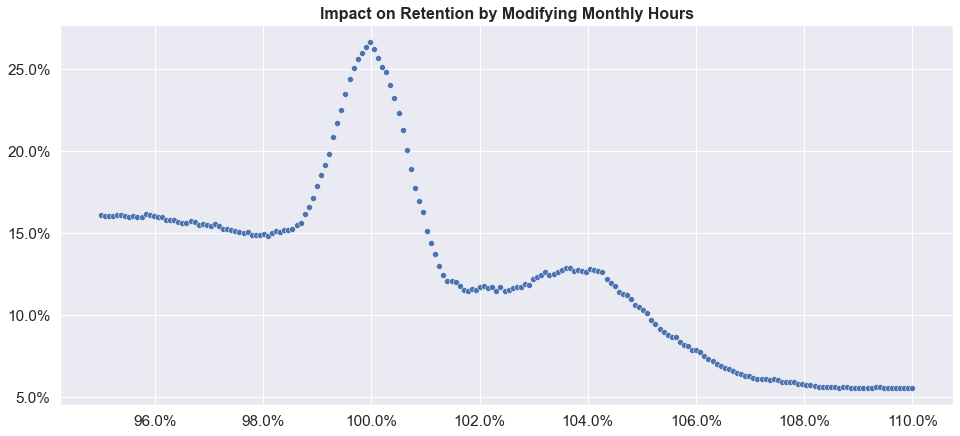

In [76]:
turnover = []
hrs_mod = np.linspace(.95, 1.1, 200)
for i in hrs_mod:
    mod_hours = pd.read_csv('data/employee_churn_data.csv')
    mod_hours.loc[mod_hours.tenure < 9, 'avg_hrs_month'] = mod_hours.loc[mod_hours.tenure < 9, 'avg_hrs_month'] * i
    mod_hours.drop('left', inplace=True, axis=1)
    X = mod_hours[variables]
    mod_hours['left'] = gbc.predict(X)
    mod_hours['turnover'] = 0
    mod_hours.loc[mod_hours.left == 'yes', 'turnover'] = 1
    turnover.append(mod_hours['turnover'].mean())


fig, ax = plt.subplots()
sns.set(
    font_scale=1.4
)
fig.set_size_inches([16,7])
ax = sns.scatterplot(
    y = turnover,
    x = hrs_mod,
)
ax.set_xticklabels(['{:,.1f}'.format(x) + '%' for x in ax.get_xticks()*100])
ax.set_yticklabels(['{:,.1f}'.format(y) + '%' for y in ax.get_yticks()*100])

ax.set_title(
    "Impact on Retention by Modifying Monthly Hours",
    fontsize = 16, 
    fontweight = 'bold'
)

### Conclusion  
This simulation demonstates increasing hours for those with less tenure will decrease turnover. 